This notebook introduces parameterized quantum circuits (PQCs) and their application as decision-making policies in reinforcement leraning (RL). At a high-level, it progresses from a single parameterized gate to a multi-layered circuit capable of learning optimal actions for classic RL tasks. **For more detailed derivations, refer to `report.pdf`**. 

Reinforcement learning involves training an agent to make decisions that maximize a task-specific reward, like keeping a pole balanced on a moving cart by deciding how to push it. A PQC is a quantum circuit that acts as a decision-making function: it takes the state of the environment, applies a sequence of unitary operations, and outputs a recommended action. The circuit’s operations are controlled by parameters, adjustable angles that we can optimize to improve decision-making.

### A Single Gate as a Trainable Decision Maker

Let’s start with a simple quantum circuit: one data-encoding gate $U_0(x)$ and one parameterized gate $U_i(\theta_i)$.

<div align="center">
    <img src="images/one-gate.png" alt="drawing" width="300"/>
</div>

The gate $U_0(x)$ takes classical input data $x$ and encodes it into a quantum state. The parameterized gate $U_i(\theta_i)$ rotates this state by an angle $\theta_i$, which we can adjust to influence the output. The circuit produces an expectation value of an observable $\hat{A}$, which we interpret as a decision, like the force we should apply. The circuit’s function is:

$$ f(x; \theta_i) = \langle x | \underbrace{U_i^\dagger(\theta_i) \hat{A} U_i(\theta_i)}_\text{rotation's effect} | x \rangle. $$

 To optimize $\theta_i$ and improve the decision, we need the gradient of this function. The parameter shift rule provides a simple way to compute it:

$$ \nabla_{\theta_i} f(x; \theta_i) = \frac{1}{2} \left[ f\left(x; \theta_i + \frac{\pi}{2}\right) - f\left(x; \theta_i - \frac{\pi}{2}\right) \right]. $$

This rule is powerful. It allows us to compute the gradient by running the circuit twice. once with the angle shifted forward by $\pi/2$ and once backward, and taking the difference. The gradient tells us how to adjust $\theta_i$ to increase the reward, allowing the circuit to learn smarter actions.

###  Multiple Gates for Complex Decisions

More gates make for a richer circuit function capable of capturing complex relationships. In realistic scenarios, quantum circuits contain multiple gates, each with its own parameter.

<div align="center">
    <img src="images/multiple-gates.png" alt="drawing" width="800"/>
</div>

This circuit chains gates $U_1(\theta_1), U_2(\theta_2), \dots, U_N(\theta_N)$, forming a unitary transformation $U(x; \theta) = U_N(\theta_N) \cdots U_1(\theta_1) U_0(x)$. The output is an expectation value that depends on all parameters $\theta = (\theta_1, \theta_2, \dots)$. This complexity can initially seem overwhelming, but to optimize a single parameter $\theta_i$, we simplify the circuit by partitioning it:

$$ f(x; \theta) = \overbrace{\langle x \vert U^\dagger_1 (\theta_1) \cdots}^{\langle \psi_{i-1} \vert} U^\dagger_i (\theta_i) \overbrace{\cdots U^\dagger_N(\theta_N) \hat{A} U_N(\theta_N) \cdots}^{\hat{A}_{i+1}} U_i (\theta_i) \overbrace{\cdots U_1(\theta_1) \vert x \rangle}^{\vert \psi_{i-1} \rangle}. $$

This partition isolates the $i$-th gate’s contributions. Gates before $U_i(\theta_i)$ are absorbed into state $| \psi_{i-1} \rangle$, and gates after it form a modified observable $\hat{A}_{i+1}$. The function becomes:

$$ f(x; \theta) = \langle \psi_{i-1} | \underbrace{U^\dagger_i (\theta_i) \hat{A}_{i+1} U_i (\theta_i)}_\text{rotation's effect} | \psi_{i-1} \rangle, $$

which mirrors the single-gate case. We can apply the parameter shift rule to compute $\nabla_{\theta_i} f(x; \theta)$ by running the circuit twice for each parameter, allowing us to tune each $\theta_i$ individually. 

### Stacking Circuit Layers

A sequence of gates on a single wire, as shown above, can only process a single input. The success of PQCs hinges on choosing an approporiate "circuit ansatz" — the structural design of the circuit. A common ansatz is the Hardware-Efficient Ansatz (HEA), which organizes gates into layers that alternate between data‑encoding and variational operations to minimize hardware noise. 

<div align="center">
    <img src="images/HEA-layers.png" alt="drawing" width="800"/>
</div>

The HEA alternates between two layer types:
* Encoding layers ($U_{\text{enc}}(\lambda, s)$) use rotation gates parameterized by trainable parameters $\lambda$ and input features $s$. By "re-uploading" data at each encoding layer, we repeatedly inject classical information and circumvent the no-cloning theorem: quantum computers cannot copy data, but classical devices can.
* Variational layers ($U_{\text{var}}(\theta)$) apply single-qubit rotations parameterized by $\theta$ followed by entangling controlled-Z gates in a circular topology. 
  
The circuit depth is the number of repetitions of these layers, and must also be tuned: deeper circuits can model more sophisicated policies but incur higher computational cost and noise.

### Optimizing the Policy with Gradients

The PQC defines a policy $\pi_{\phi}(a|s)$, which, for a given state $s$ (e.g., the pole’s angle and velocity), gives the probability of taking action $a$ (e.g., push left or right). Here, $\phi$ includes all tunable parameters, like rotation angles. We seek to optimize this policy to maximize the expected cumulative reward. To do this, we adapt a policy gradient algorithm, which works as follows:

1) Run the PQC in the environment to collect trajectories (sequences of states, actions, and rewards).
2) Calculate the reward-to-go, the total future rewards from each step, so actions are reinforced only by their consequences.
3) Use the parameter shift rule to compute gradients, running the circuit twice per parameter to see how varying $\phi$ boosts the probability of high-reward actions.
4) Update $\phi$ in the direction that increases expected rewards.
5) Repeat 1-4 until policy reliably earns high rewards.

The full implementation of this algorithm is described below, implemented in `circuit_builder.py`, and derived in `report.pdf`.

<p align="center">
    <img src="images/reinforce-algo.png" alt="drawing" width="800"/>
</p>

### Demonstration: Applying PQCs to CartPole

We apply PQCs to the `CartPole-v1` environment from Gymnasium, where the goal is to balance a pole on a moving cart. We demonstrate two uses: a speedrun for quick results and a realistic workflow for detailed control. 

The `PQC.speedrun` method builds a 5-layer PQC, trains it, and visualizes the results in one command.

In [1]:
from circuit_builder import ParameterizedQuantumCircuit as PQC, BlockSequence
from circuit_builder import *
import numpy as np
import torch

# Set random seed for reproducibility
seed = 808
np.random.seed(seed)
torch.manual_seed(seed)
np.bool8 = np.bool_  # Prevent deprecation warning

In [2]:
model = PQC.speedrun('CartPole-v1')
model.train()

Environment solved in 60 episodes! Reward=500.00

Training completed. Best reward: 500.00
Animation saved to outputs/best_performance.gif


![Animation](outputs/best_performance.gif)

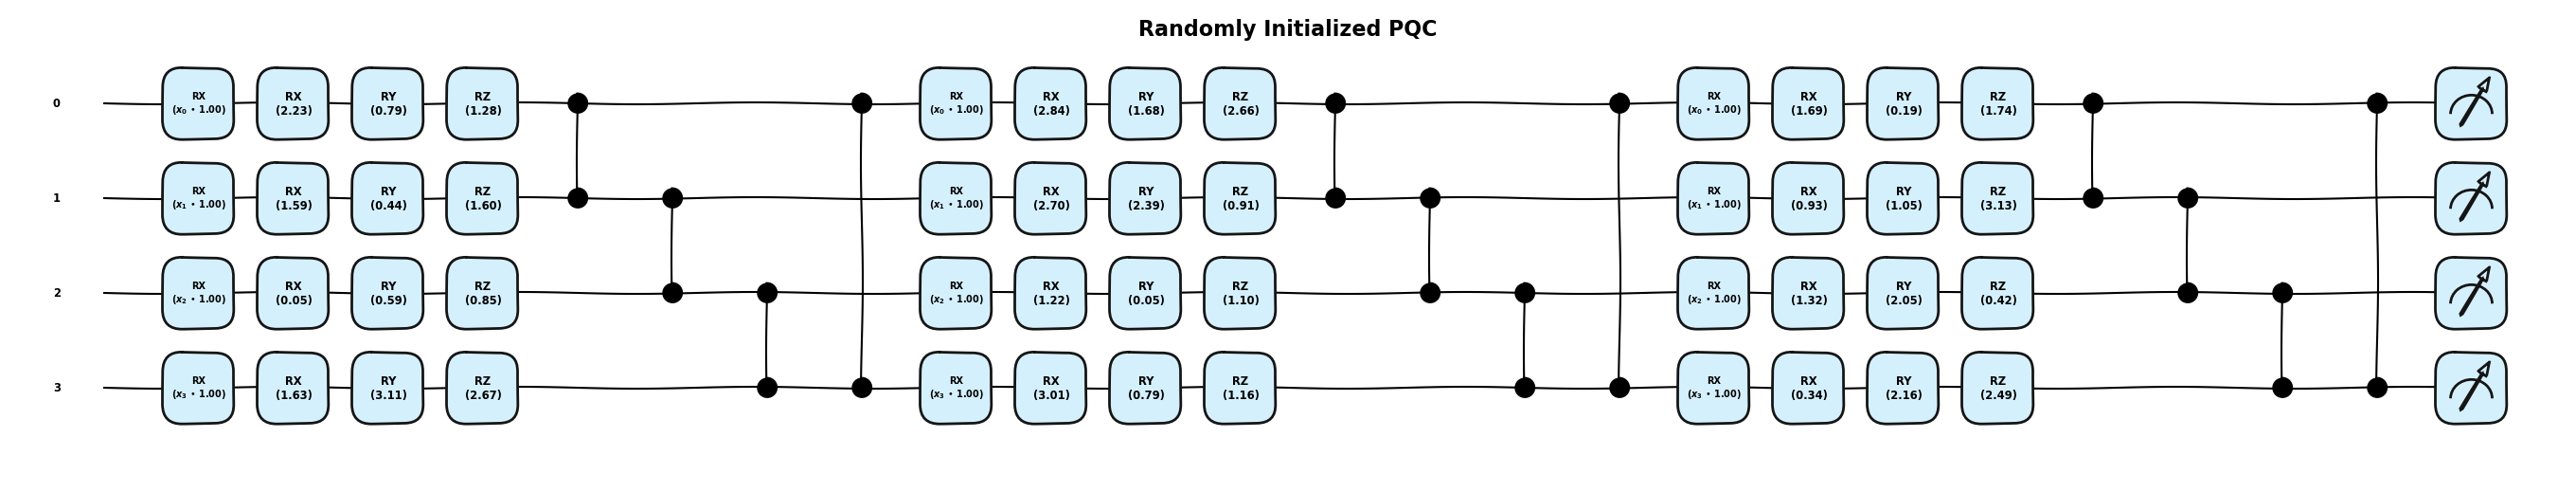

Episode 500: Reward = 402.0
Training completed. Best reward: 500.00


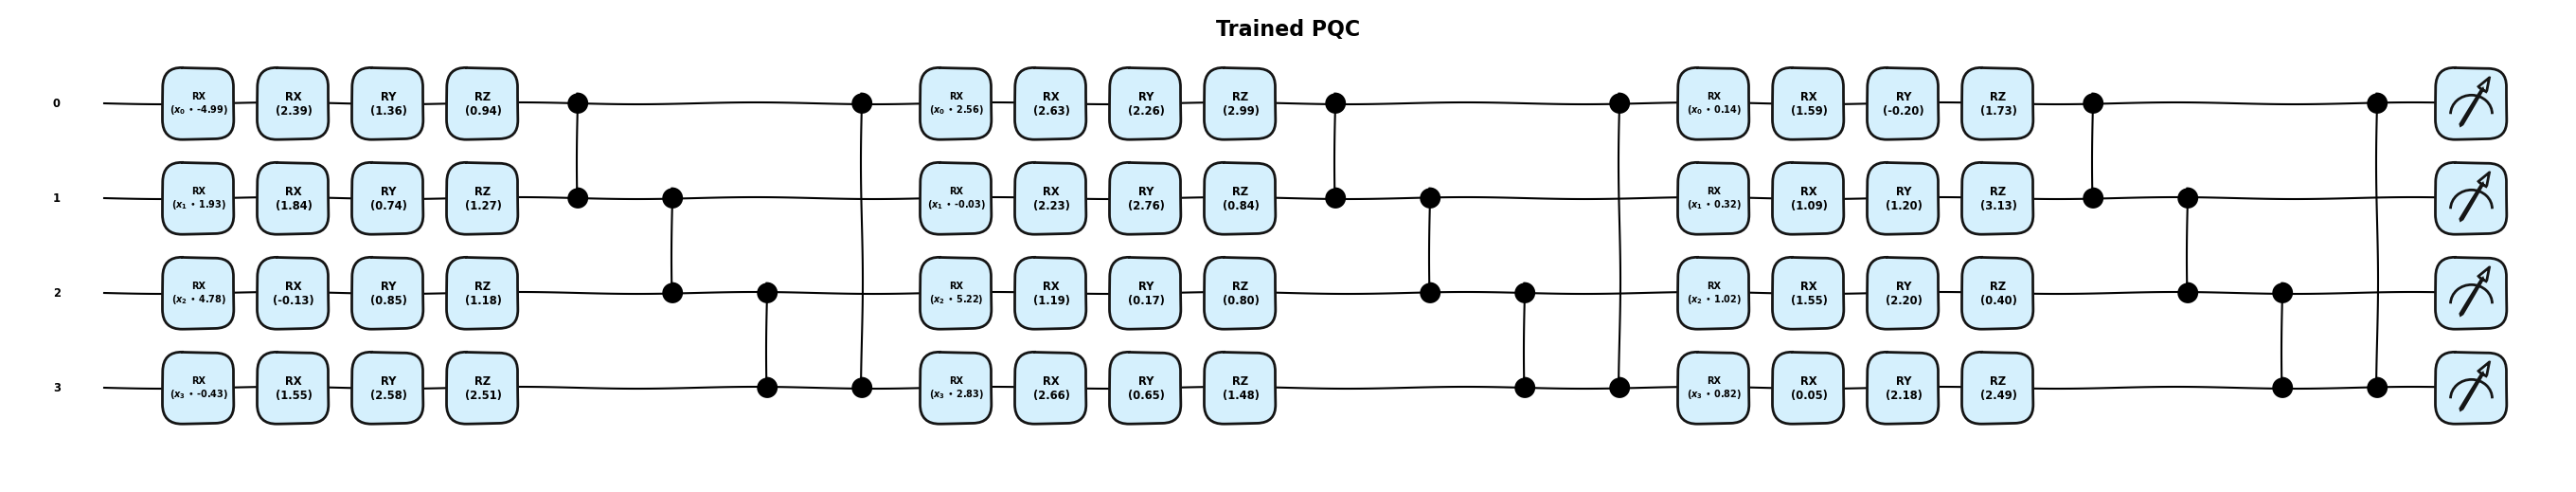

In [4]:
# Define a custom layer sequence: 3 encoding + 3 variational layers
sequence = (BlockSequence()
    .EncodingLayer()
    .VariationalLayer()
    .EncodingLayer()
    .VariationalLayer()
    .EncodingLayer()
    .VariationalLayer()
)

# Initialize the PQC with 4 qubits and custom layers
model = ParameterizedQuantumCircuit(
    env_name='CartPole-v1',
    n_qubits=4,
    beta=1.0,
    custom_blocks=sequence,
)

# Visualize the initial circuit
model.draw_circuit(
    style='pennylane_sketch',
    fontsize='small',
    dpi=300,
    title='Randomly Initialized PQC'
)

# Train the PQC
model.train(
    gamma=1.0,
    plot=True,
    save=False,
    animate=False,
    early_stopping=False,
    return_histories=False
)

# Visualize the trained circuit
model.draw_circuit(
    style='pennylane_sketch',
    fontsize='small',
    dpi=300,
    title='Trained PQC'
)